# Apr 5th, 2022 (check co-registration perf)

**Motivation**: load previous perf fit df files and analyze.  Then choose best loop parameters accordingly. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Using the following

In [2]:
kwargs = {
    'types': ['SyN', 'ElasticSyN'],
    'grads': [0.15, 0.20, 0.25, 0.28, 0.3, 0.31, 0.32, 0.34, 0.35, 0.37, 0.38, 0.39, 0.40, 0.5, 0.9],
    'syn_bins': [64, 32, 16],
    'aff_bins': [13, 20, 32],
    'aff_rates': [0.2, 0.6, 0.8],
    'aff_metric': 'mattes',
    'syn_metric': 'mattes',
    'mi_q': 0.5,
    'n_seeds': 10,
}
kwargs

{
    'types': ['SyN', 'ElasticSyN'],
    'grads': [
        0.15,
        0.2,
        0.25,
        0.28,
        0.3,
        0.31,
        0.32,
        0.34,
        0.35,
        0.37,
        0.38,
        0.39,
        0.4,
        0.5,
        0.9
    ],
    'syn_bins': [64, 32, 16],
    'aff_bins': [13, 20, 32],
    'aff_rates': [0.2, 0.6, 0.8],
    'aff_metric': 'mattes',
    'syn_metric': 'mattes',
    'mi_q': 0.5,
    'n_seeds': 10
}

## Check previous performance

In [3]:
def _bst_tx(name, df_tx, mi_q, verbose=False):
    mi = df_tx.loc[df_tx['metric'] == 'mi']
    sym = df_tx.loc[df_tx['metric'] == 'sym']
    mi = mi.reset_index(drop=True)
    sym = sym.reset_index(drop=True)
    cond = mi['score'] > np.nanquantile(mi['score'], mi_q)
    _df = sym.loc[cond]
    try:
        best_params = _df.iloc[_df['score'].argmax()]
    except ValueError:
        cond = mi['score'] > np.nanquantile(mi['score'], 2 * mi_q / 3)
        _df = sym.loc[cond]
        best_params = _df.iloc[_df['score'].argmax()]
    best_params = best_params.drop(['metric', 'score'])
    best_params = dict(best_params)
    cond = functools.reduce(
        lambda x, y: x & y, [
            df_tx[k] == v for k, v
            in best_params.items()
        ],
    )
    _df = df_tx.loc[cond]
    if verbose:
        msg = f"{name}, perf:\n\n"
        msg += f"{_df.to_string(index=False)}\n"
        print(msg)
    return best_params, _df

In [4]:
import fnmatch

pth = '/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/transforms_backup'
file_names = {}
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        key = f"sub-SLC{sub:02d}_ses-{ses}"
        candidates = fnmatch.filter(
            os.listdir(pth),
            f"fit_{key}_(*).df",
        )
        if not len(candidates):
            continue
        file_names[key] = candidates.pop()

In [5]:
dlist = []
for key, name in file_names.items():
    df_tx = pd.read_pickle(pjoin(pth, name))
    for q in [0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95]:
        best_params, _df = _bst_tx(key, df_tx, q, False)
        mi = _df.loc[_df['metric'] == 'mi', 'score'].item()
        sym = _df.loc[_df['metric'] == 'sym', 'score'].item()
        data = {
            'mi': mi,
            'sym': sym,
            **best_params,
        }
        dlist.append({
            'key': [key] * len(data),
            'q': [q] * len(data),
            'label': data.keys(),
            'value': data.values(),
        })
df_final = pd.DataFrame(merge_dicts(dlist))

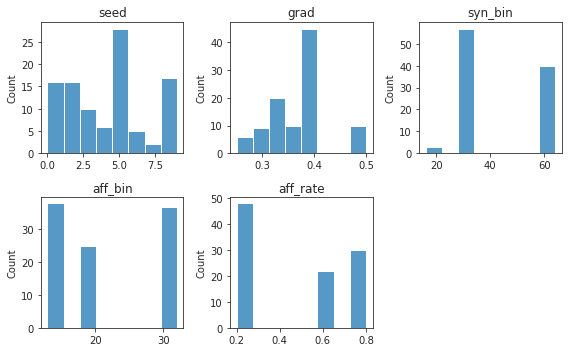

In [6]:
fig, axes = create_figure(2, 3, (8, 5))
trim_axs(axes, 5)
for ax, item in zip(axes.flat, ['seed', 'grad', 'syn_bin', 'aff_bin', 'aff_rate']):
    sns.histplot(df_final.loc[df_final['label'] == item, 'value'].values.tolist(), ax=ax)
    ax.set_title(item)

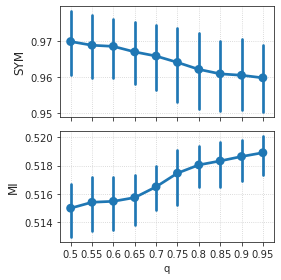

In [7]:
fig, axes = create_figure(2, 1, (4, 4), sharex='all')
sns.pointplot(data=df_final.loc[df_final['label'] == 'sym'], x='q', y='value', ax=axes[0])
sns.pointplot(data=df_final.loc[df_final['label'] == 'mi'], x='q', y='value', ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('SYM', fontsize=12)
axes[1].set_ylabel('MI', fontsize=12)
add_grid(axes)
plt.show()

### q = 0.5

In [20]:
q = 0.5
for key, name in file_names.items():
    df_tx = pd.read_pickle(pjoin(pth, name))
    _, _df = _bst_tx(key, df_tx, q, False)
    mi = _df.loc[_df['metric'] == 'mi', 'score'].item()
    sym = _df.loc[_df['metric'] == 'sym', 'score'].item()
    print(f"name: {key}   |||   q = {q}   |   sym = {sym:0.3f},  mi = {mi:0.3f}")

name: sub-SLC01_ses-2   |||   q = 0.5   |   sym = 0.978,  mi = 0.516

name: sub-SLC02_ses-2   |||   q = 0.5   |   sym = 0.954,  mi = 0.518

name: sub-SLC03_ses-2   |||   q = 0.5   |   sym = 0.970,  mi = 0.516

name: sub-SLC04_ses-2   |||   q = 0.5   |   sym = 0.980,  mi = 0.516

name: sub-SLC05_ses-2   |||   q = 0.5   |   sym = 0.974,  mi = 0.515

name: sub-SLC06_ses-2   |||   q = 0.5   |   sym = 0.966,  mi = 0.509

name: sub-SLC07_ses-2   |||   q = 0.5   |   sym = 0.959,  mi = 0.516

name: sub-SLC08_ses-2   |||   q = 0.5   |   sym = 0.943,  mi = 0.511

name: sub-SLC09_ses-2   |||   q = 0.5   |   sym = 0.985,  mi = 0.519

name: sub-SLC10_ses-2   |||   q = 0.5   |   sym = 0.990,  mi = 0.514

In [21]:
q = 0.5
for key, name in file_names.items():
    df_tx = pd.read_pickle(pjoin(pth, name))
    _ = _bst_tx(key, df_tx, q, True)

sub-SLC01_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    9 ElasticSyN  0.28       64       13       0.6       mi 0.515712
    9 ElasticSyN  0.28       64       13       0.6  ovp_MOp 0.990663
    9 ElasticSyN  0.28       64       13       0.6  sym_MOp 0.972376
    9 ElasticSyN  0.28       64       13       0.6  ovp_MOs 0.985205
    9 ElasticSyN  0.28       64       13       0.6  sym_MOs 0.991334
    9 ElasticSyN  0.28       64       13       0.6   ovp_SS 0.997000
    9 ElasticSyN  0.28       64       13       0.6   sym_SS 0.988663
    9 ElasticSyN  0.28       64       13       0.6 ovp_VISC 0.995708
    9 ElasticSyN  0.28       64       13       0.6 sym_VISC 0.925620
    9 ElasticSyN  0.28       64       13       0.6  ovp_VIS 0.999121
    9 ElasticSyN  0.28       64       13       0.6  sym_VIS 0.986038
    9 ElasticSyN  0.28       64       13       0.6   ovp_AI 0.931034
    9 ElasticSyN  0.28       64       13       0.6   sym_AI 0.986301
    9 ElasticSyN  0.28       64       13       0.6 ovp_PTLp 1.000000
    9 ElasticSyN  0.28       64       13       0.6 sym_PTLp 0.972727
    9 ElasticSyN  0.28       64       13       0.6  ovp_TEa 1.000000
    9 ElasticSyN  0.28       64       13       0.6  sym_TEa 0.915493
    9 ElasticSyN  0.28       64       13       0.6  ovp_CA1 1.000000
    9 ElasticSyN  0.28       64       13       0.6  sym_CA1 0.893665
    9 ElasticSyN  0.28       64       13       0.6  ovp_CLA 1.000000
    9 ElasticSyN  0.28       64       13       0.6  sym_CLA 0.964286
    9 ElasticSyN  0.28       64       13       0.6 ovp_STRd 1.000000
    9 ElasticSyN  0.28       64       13       0.6 sym_STRd 0.997856
    9 ElasticSyN  0.28       64       13       0.6  ovp_iso 0.989255
    9 ElasticSyN  0.28       64       13       0.6  sym_iso 0.981494
    9 ElasticSyN  0.28       64       13       0.6      sym 0.977608
    9 ElasticSyN  0.28       64       13       0.6      ovp 0.992205

sub-SLC02_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    4 ElasticSyN  0.32       64       32       0.6       mi 0.517971
    4 ElasticSyN  0.32       64       32       0.6  ovp_MOp 0.994470
    4 ElasticSyN  0.32       64       32       0.6  sym_MOp 0.923759
    4 ElasticSyN  0.32       64       32       0.6  ovp_MOs 0.999133
    4 ElasticSyN  0.32       64       32       0.6  sym_MOs 0.947635
    4 ElasticSyN  0.32       64       32       0.6   ovp_SS 1.000000
    4 ElasticSyN  0.32       64       32       0.6   sym_SS 0.979114
    4 ElasticSyN  0.32       64       32       0.6 ovp_VISC 0.990654
    4 ElasticSyN  0.32       64       32       0.6 sym_VISC 0.963303
    4 ElasticSyN  0.32       64       32       0.6  ovp_VIS 1.000000
    4 ElasticSyN  0.32       64       32       0.6  sym_VIS 0.978761
    4 ElasticSyN  0.32       64       32       0.6   ovp_AI 0.965309
    4 ElasticSyN  0.32       64       32       0.6   sym_AI 0.973214
    4 ElasticSyN  0.32       64       32       0.6 ovp_PTLp 1.000000
    4 ElasticSyN  0.32       64       32       0.6 sym_PTLp 0.936937
    4 ElasticSyN  0.32       64       32       0.6  ovp_TEa 1.000000
    4 ElasticSyN  0.32       64       32       0.6  sym_TEa 0.992248
    4 ElasticSyN  0.32       64       32       0.6  ovp_CA1 1.000000
    4 ElasticSyN  0.32       64       32       0.6  sym_CA1 0.942446
    4 ElasticSyN  0.32       64       32       0.6  ovp_CLA 1.000000
    4 ElasticSyN  0.32       64       32       0.6  sym_CLA 0.843750
    4 ElasticSyN  0.32       64       32       0.6 ovp_STRd 1.000000
    4 ElasticSyN  0.32       64       32       0.6 sym_STRd 0.923420
    4 ElasticSyN  0.32       64       32       0.6  ovp_iso 0.995571
    4 ElasticSyN  0.32       64       32       0.6  sym_iso 1.000000
    4 ElasticSyN  0.32       64       32       0.6      sym 0.954152
    4 ElasticSyN  0.32       64       32       0.6      ovp 0.997014

sub-SLC03_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    2 ElasticSyN  0.35       64       13       0.8       mi 0.515555
    2 ElasticSyN  0.35       64       13       0.8  ovp_MOp 0.985929
    2 ElasticSyN  0.35       64       13       0.8  sym_MOp 0.966790
    2 ElasticSyN  0.35       64       13       0.8  ovp_MOs 0.996276
    2 ElasticSyN  0.35       64       13       0.8  sym_MOs 0.942134
    2 ElasticSyN  0.35       64       13       0.8   ovp_SS 0.992707
    2 ElasticSyN  0.35       64       13       0.8   sym_SS 0.995755
    2 ElasticSyN  0.35       64       13       0.8 ovp_VISC 0.991189
    2 ElasticSyN  0.35       64       13       0.8 sym_VISC 0.991228
    2 ElasticSyN  0.35       64       13       0.8  ovp_VIS 0.993311
    2 ElasticSyN  0.35       64       13       0.8  sym_VIS 0.993333
    2 ElasticSyN  0.35       64       13       0.8   ovp_AI 0.952120
    2 ElasticSyN  0.35       64       13       0.8   sym_AI 0.965054
    2 ElasticSyN  0.35       64       13       0.8 ovp_PTLp 0.995726
    2 ElasticSyN  0.35       64       13       0.8 sym_PTLp 0.983051
    2 ElasticSyN  0.35       64       13       0.8  ovp_TEa 1.000000
    2 ElasticSyN  0.35       64       13       0.8  sym_TEa 0.898734
    2 ElasticSyN  0.35       64       13       0.8  ovp_CA1 1.000000
    2 ElasticSyN  0.35       64       13       0.8  sym_CA1 0.861233
    2 ElasticSyN  0.35       64       13       0.8  ovp_CLA 1.000000
    2 ElasticSyN  0.35       64       13       0.8  sym_CLA 0.967742
    2 ElasticSyN  0.35       64       13       0.8 ovp_STRd 1.000000
    2 ElasticSyN  0.35       64       13       0.8 sym_STRd 0.991758
    2 ElasticSyN  0.35       64       13       0.8  ovp_iso 0.989174
    2 ElasticSyN  0.35       64       13       0.8  sym_iso 0.969564
    2 ElasticSyN  0.35       64       13       0.8      sym 0.970329
    2 ElasticSyN  0.35       64       13       0.8      ovp 0.992326

sub-SLC04_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    8  SyN  0.25       64       20       0.8       mi 0.516059
    8  SyN  0.25       64       20       0.8  ovp_MOp 0.986807
    8  SyN  0.25       64       20       0.8  sym_MOp 0.998243
    8  SyN  0.25       64       20       0.8  ovp_MOs 0.989673
    8  SyN  0.25       64       20       0.8  sym_MOs 0.996564
    8  SyN  0.25       64       20       0.8   ovp_SS 0.998596
    8  SyN  0.25       64       20       0.8   sym_SS 0.989944
    8  SyN  0.25       64       20       0.8 ovp_VISC 1.000000
    8  SyN  0.25       64       20       0.8 sym_VISC 0.983740
    8  SyN  0.25       64       20       0.8  ovp_VIS 0.998400
    8  SyN  0.25       64       20       0.8  sym_VIS 0.993620
    8  SyN  0.25       64       20       0.8   ovp_AI 0.952685
    8  SyN  0.25       64       20       0.8   sym_AI 0.994898
    8  SyN  0.25       64       20       0.8 ovp_PTLp 1.000000
    8  SyN  0.25       64       20       0.8 sym_PTLp 0.943089
    8  SyN  0.25       64       20       0.8  ovp_TEa 1.000000
    8  SyN  0.25       64       20       0.8  sym_TEa 0.939597
    8  SyN  0.25       64       20       0.8  ovp_CA1 1.000000
    8  SyN  0.25       64       20       0.8  sym_CA1 0.870518
    8  SyN  0.25       64       20       0.8  ovp_CLA 1.000000
    8  SyN  0.25       64       20       0.8  sym_CLA 0.783784
    8  SyN  0.25       64       20       0.8 ovp_STRd 1.000000
    8  SyN  0.25       64       20       0.8 sym_STRd 0.996619
    8  SyN  0.25       64       20       0.8  ovp_iso 0.991937
    8  SyN  0.25       64       20       0.8  sym_iso 0.969947
    8  SyN  0.25       64       20       0.8      sym 0.980407
    8  SyN  0.25       64       20       0.8      ovp 0.994135

sub-SLC05_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    3 ElasticSyN  0.39       64       13       0.8       mi 0.515422
    3 ElasticSyN  0.39       64       13       0.8  ovp_MOp 0.999077
    3 ElasticSyN  0.39       64       13       0.8  sym_MOp 0.981718
    3 ElasticSyN  0.39       64       13       0.8  ovp_MOs 0.996454
    3 ElasticSyN  0.39       64       13       0.8  sym_MOs 0.948187
    3 ElasticSyN  0.39       64       13       0.8   ovp_SS 0.998800
    3 ElasticSyN  0.39       64       13       0.8   sym_SS 0.991632
    3 ElasticSyN  0.39       64       13       0.8 ovp_VISC 0.995575
    3 ElasticSyN  0.39       64       13       0.8 sym_VISC 0.965217
    3 ElasticSyN  0.39       64       13       0.8  ovp_VIS 1.000000
    3 ElasticSyN  0.39       64       13       0.8  sym_VIS 0.994845
    3 ElasticSyN  0.39       64       13       0.8   ovp_AI 0.958506
    3 ElasticSyN  0.39       64       13       0.8   sym_AI 0.991736
    3 ElasticSyN  0.39       64       13       0.8 ovp_PTLp 1.000000
    3 ElasticSyN  0.39       64       13       0.8 sym_PTLp 0.945455
    3 ElasticSyN  0.39       64       13       0.8  ovp_TEa 1.000000
    3 ElasticSyN  0.39       64       13       0.8  sym_TEa 0.859873
    3 ElasticSyN  0.39       64       13       0.8  ovp_CA1 1.000000
    3 ElasticSyN  0.39       64       13       0.8  sym_CA1 0.950739
    3 ElasticSyN  0.39       64       13       0.8  ovp_CLA 1.000000
    3 ElasticSyN  0.39       64       13       0.8  sym_CLA 0.823529
    3 ElasticSyN  0.39       64       13       0.8 ovp_STRd 1.000000
    3 ElasticSyN  0.39       64       13       0.8 sym_STRd 0.974101
    3 ElasticSyN  0.39       64       13       0.8  ovp_iso 0.995762
    3 ElasticSyN  0.39       64       13       0.8  sym_iso 0.989585
    3 ElasticSyN  0.39       64       13       0.8      sym 0.973956
    3 ElasticSyN  0.39       64       13       0.8      ovp 0.996492

sub-SLC06_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    6 ElasticSyN  0.39       16       13       0.2       mi 0.508633
    6 ElasticSyN  0.39       16       13       0.2  ovp_MOp 0.985348
    6 ElasticSyN  0.39       16       13       0.2  sym_MOp 0.989071
    6 ElasticSyN  0.39       16       13       0.2  ovp_MOs 0.984808
    6 ElasticSyN  0.39       16       13       0.2  sym_MOs 0.991103
    6 ElasticSyN  0.39       16       13       0.2   ovp_SS 0.999238
    6 ElasticSyN  0.39       16       13       0.2   sym_SS 0.990389
    6 ElasticSyN  0.39       16       13       0.2 ovp_VISC 0.992620
    6 ElasticSyN  0.39       16       13       0.2 sym_VISC 0.978102
    6 ElasticSyN  0.39       16       13       0.2  ovp_VIS 0.999096
    6 ElasticSyN  0.39       16       13       0.2  sym_VIS 0.910190
    6 ElasticSyN  0.39       16       13       0.2   ovp_AI 0.925599
    6 ElasticSyN  0.39       16       13       0.2   sym_AI 0.977556
    6 ElasticSyN  0.39       16       13       0.2 ovp_PTLp 1.000000
    6 ElasticSyN  0.39       16       13       0.2 sym_PTLp 0.867188
    6 ElasticSyN  0.39       16       13       0.2  ovp_TEa 1.000000
    6 ElasticSyN  0.39       16       13       0.2  sym_TEa 0.982759
    6 ElasticSyN  0.39       16       13       0.2  ovp_CA1 1.000000
    6 ElasticSyN  0.39       16       13       0.2  sym_CA1 0.996988
    6 ElasticSyN  0.39       16       13       0.2  ovp_CLA 1.000000
    6 ElasticSyN  0.39       16       13       0.2  sym_CLA 0.888889
    6 ElasticSyN  0.39       16       13       0.2 ovp_STRd 1.000000
    6 ElasticSyN  0.39       16       13       0.2 sym_STRd 0.933190
    6 ElasticSyN  0.39       16       13       0.2  ovp_iso 0.988989
    6 ElasticSyN  0.39       16       13       0.2  sym_iso 0.986934
    6 ElasticSyN  0.39       16       13       0.2      sym 0.966020
    6 ElasticSyN  0.39       16       13       0.2      ovp 0.991869

sub-SLC07_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    5  SyN  0.25       64       32       0.8       mi 0.516234
    5  SyN  0.25       64       32       0.8  ovp_MOp 0.981326
    5  SyN  0.25       64       32       0.8  sym_MOp 0.987013
    5  SyN  0.25       64       32       0.8  ovp_MOs 0.989700
    5  SyN  0.25       64       32       0.8  sym_MOs 1.000000
    5  SyN  0.25       64       32       0.8   ovp_SS 0.994484
    5  SyN  0.25       64       32       0.8   sym_SS 0.990848
    5  SyN  0.25       64       32       0.8 ovp_VISC 1.000000
    5  SyN  0.25       64       32       0.8 sym_VISC 0.941176
    5  SyN  0.25       64       32       0.8  ovp_VIS 0.999211
    5  SyN  0.25       64       32       0.8  sym_VIS 0.976599
    5  SyN  0.25       64       32       0.8   ovp_AI 0.939808
    5  SyN  0.25       64       32       0.8   sym_AI 0.954545
    5  SyN  0.25       64       32       0.8 ovp_PTLp 1.000000
    5  SyN  0.25       64       32       0.8 sym_PTLp 0.950000
    5  SyN  0.25       64       32       0.8  ovp_TEa 0.996454
    5  SyN  0.25       64       32       0.8  sym_TEa 0.867550
    5  SyN  0.25       64       32       0.8  ovp_CA1 1.000000
    5  SyN  0.25       64       32       0.8  sym_CA1 0.823404
    5  SyN  0.25       64       32       0.8  ovp_CLA 1.000000
    5  SyN  0.25       64       32       0.8  sym_CLA 0.806452
    5  SyN  0.25       64       32       0.8 ovp_STRd 1.000000
    5  SyN  0.25       64       32       0.8 sym_STRd 0.945927
    5  SyN  0.25       64       32       0.8  ovp_iso 0.988134
    5  SyN  0.25       64       32       0.8  sym_iso 0.976222
    5  SyN  0.25       64       32       0.8      sym 0.958624
    5  SyN  0.25       64       32       0.8      ovp 0.991709

sub-SLC08_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    0 ElasticSyN  0.37       64       13       0.2       mi 0.510726
    0 ElasticSyN  0.37       64       13       0.2  ovp_MOp 0.990214
    0 ElasticSyN  0.37       64       13       0.2  sym_MOp 0.921368
    0 ElasticSyN  0.37       64       13       0.2  ovp_MOs 0.996584
    0 ElasticSyN  0.37       64       13       0.2  sym_MOs 0.991497
    0 ElasticSyN  0.37       64       13       0.2   ovp_SS 0.997102
    0 ElasticSyN  0.37       64       13       0.2   sym_SS 0.989049
    0 ElasticSyN  0.37       64       13       0.2 ovp_VISC 1.000000
    0 ElasticSyN  0.37       64       13       0.2 sym_VISC 0.840000
    0 ElasticSyN  0.37       64       13       0.2  ovp_VIS 0.997460
    0 ElasticSyN  0.37       64       13       0.2  sym_VIS 0.974916
    0 ElasticSyN  0.37       64       13       0.2   ovp_AI 0.934605
    0 ElasticSyN  0.37       64       13       0.2   sym_AI 0.994565
    0 ElasticSyN  0.37       64       13       0.2 ovp_PTLp 1.000000
    0 ElasticSyN  0.37       64       13       0.2 sym_PTLp 0.958333
    0 ElasticSyN  0.37       64       13       0.2  ovp_TEa 1.000000
    0 ElasticSyN  0.37       64       13       0.2  sym_TEa 0.878981
    0 ElasticSyN  0.37       64       13       0.2  ovp_CA1 1.000000
    0 ElasticSyN  0.37       64       13       0.2  sym_CA1 0.823666
    0 ElasticSyN  0.37       64       13       0.2  ovp_CLA 1.000000
    0 ElasticSyN  0.37       64       13       0.2  sym_CLA 1.000000
    0 ElasticSyN  0.37       64       13       0.2 ovp_STRd 1.000000
    0 ElasticSyN  0.37       64       13       0.2 sym_STRd 0.900556
    0 ElasticSyN  0.37       64       13       0.2  ovp_iso 0.990929
    0 ElasticSyN  0.37       64       13       0.2  sym_iso 0.986129
    0 ElasticSyN  0.37       64       13       0.2      sym 0.943441
    0 ElasticSyN  0.37       64       13       0.2      ovp 0.993522

sub-SLC09_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    5  SyN   0.4       32       13       0.2       mi 0.519319
    5  SyN   0.4       32       13       0.2  ovp_MOp 0.984155
    5  SyN   0.4       32       13       0.2  sym_MOp 0.968804
    5  SyN   0.4       32       13       0.2  ovp_MOs 0.989455
    5  SyN   0.4       32       13       0.2  sym_MOs 0.962069
    5  SyN   0.4       32       13       0.2   ovp_SS 0.996241
    5  SyN   0.4       32       13       0.2   sym_SS 0.990789
    5  SyN   0.4       32       13       0.2 ovp_VISC 0.986607
    5  SyN   0.4       32       13       0.2 sym_VISC 0.982301
    5  SyN   0.4       32       13       0.2  ovp_VIS 0.995912
    5  SyN   0.4       32       13       0.2  sym_VIS 0.995106
    5  SyN   0.4       32       13       0.2   ovp_AI 0.954208
    5  SyN   0.4       32       13       0.2   sym_AI 1.000000
    5  SyN   0.4       32       13       0.2 ovp_PTLp 1.000000
    5  SyN   0.4       32       13       0.2 sym_PTLp 0.950413
    5  SyN   0.4       32       13       0.2  ovp_TEa 0.996540
    5  SyN   0.4       32       13       0.2  sym_TEa 0.979452
    5  SyN   0.4       32       13       0.2  ovp_CA1 1.000000
    5  SyN   0.4       32       13       0.2  sym_CA1 0.984018
    5  SyN   0.4       32       13       0.2  ovp_CLA 1.000000
    5  SyN   0.4       32       13       0.2  sym_CLA 0.825000
    5  SyN   0.4       32       13       0.2 ovp_STRd 1.000000
    5  SyN   0.4       32       13       0.2 sym_STRd 0.993377
    5  SyN   0.4       32       13       0.2  ovp_iso 0.990201
    5  SyN   0.4       32       13       0.2  sym_iso 0.987648
    5  SyN   0.4       32       13       0.2      sym 0.984801
    5  SyN   0.4       32       13       0.2      ovp 0.992719

sub-SLC10_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    6 ElasticSyN  0.35       64       20       0.6       mi 0.514254
    6 ElasticSyN  0.35       64       20       0.6  ovp_MOp 0.981366
    6 ElasticSyN  0.35       64       20       0.6  sym_MOp 0.984155
    6 ElasticSyN  0.35       64       20       0.6  ovp_MOs 0.990598
    6 ElasticSyN  0.35       64       20       0.6  sym_MOs 1.000000
    6 ElasticSyN  0.35       64       20       0.6   ovp_SS 0.998493
    6 ElasticSyN  0.35       64       20       0.6   sym_SS 0.998193
    6 ElasticSyN  0.35       64       20       0.6 ovp_VISC 1.000000
    6 ElasticSyN  0.35       64       20       0.6 sym_VISC 0.991150
    6 ElasticSyN  0.35       64       20       0.6  ovp_VIS 1.000000
    6 ElasticSyN  0.35       64       20       0.6  sym_VIS 0.996727
    6 ElasticSyN  0.35       64       20       0.6   ovp_AI 0.964237
    6 ElasticSyN  0.35       64       20       0.6   sym_AI 0.964865
    6 ElasticSyN  0.35       64       20       0.6 ovp_PTLp 1.000000
    6 ElasticSyN  0.35       64       20       0.6 sym_PTLp 0.956522
    6 ElasticSyN  0.35       64       20       0.6  ovp_TEa 1.000000
    6 ElasticSyN  0.35       64       20       0.6  sym_TEa 0.986207
    6 ElasticSyN  0.35       64       20       0.6  ovp_CA1 1.000000
    6 ElasticSyN  0.35       64       20       0.6  sym_CA1 0.992366
    6 ElasticSyN  0.35       64       20       0.6  ovp_CLA 1.000000
    6 ElasticSyN  0.35       64       20       0.6  sym_CLA 0.866667
    6 ElasticSyN  0.35       64       20       0.6 ovp_STRd 1.000000
    6 ElasticSyN  0.35       64       20       0.6 sym_STRd 0.984093
    6 ElasticSyN  0.35       64       20       0.6  ovp_iso 0.991236
    6 ElasticSyN  0.35       64       20       0.6  sym_iso 0.984061
    6 ElasticSyN  0.35       64       20       0.6      sym 0.989531
    6 ElasticSyN  0.35       64       20       0.6      ovp 0.994615

### q = 0.8

In [22]:
q = 0.8
for key, name in file_names.items():
    df_tx = pd.read_pickle(pjoin(pth, name))
    _, _df = _bst_tx(key, df_tx, q, False)
    mi = _df.loc[_df['metric'] == 'mi', 'score'].item()
    sym = _df.loc[_df['metric'] == 'sym', 'score'].item()
    print(f"name: {key}   |||   q = {q}   |   sym = {sym:0.3f},  mi = {mi:0.3f}")

name: sub-SLC01_ses-2   |||   q = 0.8   |   sym = 0.974,  mi = 0.518

name: sub-SLC02_ses-2   |||   q = 0.8   |   sym = 0.940,  mi = 0.521

name: sub-SLC03_ses-2   |||   q = 0.8   |   sym = 0.968,  mi = 0.518

name: sub-SLC04_ses-2   |||   q = 0.8   |   sym = 0.973,  mi = 0.520

name: sub-SLC05_ses-2   |||   q = 0.8   |   sym = 0.962,  mi = 0.516

name: sub-SLC06_ses-2   |||   q = 0.8   |   sym = 0.960,  mi = 0.512

name: sub-SLC07_ses-2   |||   q = 0.8   |   sym = 0.956,  mi = 0.520

name: sub-SLC08_ses-2   |||   q = 0.8   |   sym = 0.927,  mi = 0.517

name: sub-SLC09_ses-2   |||   q = 0.8   |   sym = 0.985,  mi = 0.519

name: sub-SLC10_ses-2   |||   q = 0.8   |   sym = 0.978,  mi = 0.518

In [23]:
q = 0.8
for key, name in file_names.items():
    df_tx = pd.read_pickle(pjoin(pth, name))
    _ = _bst_tx(key, df_tx, q, True)

sub-SLC01_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    3 ElasticSyN   0.4       32       13       0.2       mi 0.517980
    3 ElasticSyN   0.4       32       13       0.2  ovp_MOp 0.986805
    3 ElasticSyN   0.4       32       13       0.2  sym_MOp 0.998117
    3 ElasticSyN   0.4       32       13       0.2  ovp_MOs 0.979574
    3 ElasticSyN   0.4       32       13       0.2  sym_MOs 0.994907
    3 ElasticSyN   0.4       32       13       0.2   ovp_SS 0.996749
    3 ElasticSyN   0.4       32       13       0.2   sym_SS 0.987082
    3 ElasticSyN   0.4       32       13       0.2 ovp_VISC 0.991561
    3 ElasticSyN   0.4       32       13       0.2 sym_VISC 0.942623
    3 ElasticSyN   0.4       32       13       0.2  ovp_VIS 0.997300
    3 ElasticSyN   0.4       32       13       0.2  sym_VIS 0.987478
    3 ElasticSyN   0.4       32       13       0.2   ovp_AI 0.924222
    3 ElasticSyN   0.4       32       13       0.2   sym_AI 0.955026
    3 ElasticSyN   0.4       32       13       0.2 ovp_PTLp 1.000000
    3 ElasticSyN   0.4       32       13       0.2 sym_PTLp 0.982609
    3 ElasticSyN   0.4       32       13       0.2  ovp_TEa 1.000000
    3 ElasticSyN   0.4       32       13       0.2  sym_TEa 0.952703
    3 ElasticSyN   0.4       32       13       0.2  ovp_CA1 1.000000
    3 ElasticSyN   0.4       32       13       0.2  sym_CA1 0.877698
    3 ElasticSyN   0.4       32       13       0.2  ovp_CLA 1.000000
    3 ElasticSyN   0.4       32       13       0.2  sym_CLA 0.968750
    3 ElasticSyN   0.4       32       13       0.2 ovp_STRd 1.000000
    3 ElasticSyN   0.4       32       13       0.2 sym_STRd 0.977569
    3 ElasticSyN   0.4       32       13       0.2  ovp_iso 0.987167
    3 ElasticSyN   0.4       32       13       0.2  sym_iso 0.998685
    3 ElasticSyN   0.4       32       13       0.2      sym 0.973975
    3 ElasticSyN   0.4       32       13       0.2      ovp 0.990478

sub-SLC02_ses-2, perf:

 seed     type  grad  syn_bin  aff_bin  aff_rate   metric    score
    0 SyNAggro   0.5       32       32       0.8       mi 0.521277
    0 SyNAggro   0.5       32       32       0.8  ovp_MOp 0.994361
    0 SyNAggro   0.5       32       32       0.8  sym_MOp 0.903399
    0 SyNAggro   0.5       32       32       0.8  ovp_MOs 1.000000
    0 SyNAggro   0.5       32       32       0.8  sym_MOs 0.884354
    0 SyNAggro   0.5       32       32       0.8   ovp_SS 0.999030
    0 SyNAggro   0.5       32       32       0.8   sym_SS 0.976982
    0 SyNAggro   0.5       32       32       0.8 ovp_VISC 0.995392
    0 SyNAggro   0.5       32       32       0.8 sym_VISC 0.838983
    0 SyNAggro   0.5       32       32       0.8  ovp_VIS 0.999026
    0 SyNAggro   0.5       32       32       0.8  sym_VIS 0.934087
    0 SyNAggro   0.5       32       32       0.8   ovp_AI 0.974684
    0 SyNAggro   0.5       32       32       0.8   sym_AI 0.975000
    0 SyNAggro   0.5       32       32       0.8 ovp_PTLp 1.000000
    0 SyNAggro   0.5       32       32       0.8 sym_PTLp 0.962617
    0 SyNAggro   0.5       32       32       0.8  ovp_TEa 1.000000
    0 SyNAggro   0.5       32       32       0.8  sym_TEa 0.969925
    0 SyNAggro   0.5       32       32       0.8  ovp_CA1 1.000000
    0 SyNAggro   0.5       32       32       0.8  sym_CA1 0.876923
    0 SyNAggro   0.5       32       32       0.8  ovp_CLA 1.000000
    0 SyNAggro   0.5       32       32       0.8  sym_CLA 0.968750
    0 SyNAggro   0.5       32       32       0.8 ovp_STRd 1.000000
    0 SyNAggro   0.5       32       32       0.8 sym_STRd 0.955438
    0 SyNAggro   0.5       32       32       0.8  ovp_iso 0.995524
    0 SyNAggro   0.5       32       32       0.8  sym_iso 0.995971
    0 SyNAggro   0.5       32       32       0.8      sym 0.939692
    0 SyNAggro   0.5       32       32       0.8      ovp 0.997416

sub-SLC03_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    1  SyN  0.32       32       32       0.8       mi 0.518391
    1  SyN  0.32       32       32       0.8  ovp_MOp 0.984875
    1  SyN  0.32       32       32       0.8  sym_MOp 0.965035
    1  SyN  0.32       32       32       0.8  ovp_MOs 0.992952
    1  SyN  0.32       32       32       0.8  sym_MOs 0.956897
    1  SyN  0.32       32       32       0.8   ovp_SS 0.996320
    1  SyN  0.32       32       32       0.8   sym_SS 0.993276
    1  SyN  0.32       32       32       0.8 ovp_VISC 1.000000
    1  SyN  0.32       32       32       0.8 sym_VISC 0.918033
    1  SyN  0.32       32       32       0.8  ovp_VIS 1.000000
    1  SyN  0.32       32       32       0.8  sym_VIS 0.991197
    1  SyN  0.32       32       32       0.8   ovp_AI 0.951187
    1  SyN  0.32       32       32       0.8   sym_AI 0.968831
    1  SyN  0.32       32       32       0.8 ovp_PTLp 1.000000
    1  SyN  0.32       32       32       0.8 sym_PTLp 0.972222
    1  SyN  0.32       32       32       0.8  ovp_TEa 1.000000
    1  SyN  0.32       32       32       0.8  sym_TEa 0.812500
    1  SyN  0.32       32       32       0.8  ovp_CA1 1.000000
    1  SyN  0.32       32       32       0.8  sym_CA1 0.853933
    1  SyN  0.32       32       32       0.8  ovp_CLA 1.000000
    1  SyN  0.32       32       32       0.8  sym_CLA 0.852941
    1  SyN  0.32       32       32       0.8 ovp_STRd 1.000000
    1  SyN  0.32       32       32       0.8 sym_STRd 0.998595
    1  SyN  0.32       32       32       0.8  ovp_iso 0.990354
    1  SyN  0.32       32       32       0.8  sym_iso 0.975729
    1  SyN  0.32       32       32       0.8      sym 0.967621
    1  SyN  0.32       32       32       0.8      ovp 0.993771

sub-SLC04_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    2  SyN   0.4       32       32       0.2       mi 0.520228
    2  SyN   0.4       32       32       0.2  ovp_MOp 0.986339
    2  SyN   0.4       32       32       0.2  sym_MOp 0.978378
    2  SyN   0.4       32       32       0.2  ovp_MOs 0.991071
    2  SyN   0.4       32       32       0.2  sym_MOs 0.975309
    2  SyN   0.4       32       32       0.2   ovp_SS 0.998333
    2  SyN   0.4       32       32       0.2   sym_SS 0.995011
    2  SyN   0.4       32       32       0.2 ovp_VISC 0.996183
    2  SyN   0.4       32       32       0.2 sym_VISC 0.912409
    2  SyN   0.4       32       32       0.2  ovp_VIS 0.998298
    2  SyN   0.4       32       32       0.2  sym_VIS 0.998299
    2  SyN   0.4       32       32       0.2   ovp_AI 0.953518
    2  SyN   0.4       32       32       0.2   sym_AI 1.000000
    2  SyN   0.4       32       32       0.2 ovp_PTLp 1.000000
    2  SyN   0.4       32       32       0.2 sym_PTLp 0.909836
    2  SyN   0.4       32       32       0.2  ovp_TEa 1.000000
    2  SyN   0.4       32       32       0.2  sym_TEa 0.882716
    2  SyN   0.4       32       32       0.2  ovp_CA1 1.000000
    2  SyN   0.4       32       32       0.2  sym_CA1 0.895592
    2  SyN   0.4       32       32       0.2  ovp_CLA 1.000000
    2  SyN   0.4       32       32       0.2  sym_CLA 0.875000
    2  SyN   0.4       32       32       0.2 ovp_STRd 1.000000
    2  SyN   0.4       32       32       0.2 sym_STRd 0.975626
    2  SyN   0.4       32       32       0.2  ovp_iso 0.991591
    2  SyN   0.4       32       32       0.2  sym_iso 0.971996
    2  SyN   0.4       32       32       0.2      sym 0.973157
    2  SyN   0.4       32       32       0.2      ovp 0.994138

sub-SLC05_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    5  SyN  0.37       64       13       0.8       mi 0.516483
    5  SyN  0.37       64       13       0.8  ovp_MOp 0.999076
    5  SyN  0.37       64       13       0.8  sym_MOp 0.974453
    5  SyN  0.37       64       13       0.8  ovp_MOs 0.997300
    5  SyN  0.37       64       13       0.8  sym_MOs 0.987478
    5  SyN  0.37       64       13       0.8   ovp_SS 1.000000
    5  SyN  0.37       64       13       0.8   sym_SS 0.979530
    5  SyN  0.37       64       13       0.8 ovp_VISC 0.995690
    5  SyN  0.37       64       13       0.8 sym_VISC 0.966102
    5  SyN  0.37       64       13       0.8  ovp_VIS 0.998331
    5  SyN  0.37       64       13       0.8  sym_VIS 0.895570
    5  SyN  0.37       64       13       0.8   ovp_AI 0.961749
    5  SyN  0.37       64       13       0.8   sym_AI 0.967742
    5  SyN  0.37       64       13       0.8 ovp_PTLp 1.000000
    5  SyN  0.37       64       13       0.8 sym_PTLp 0.945455
    5  SyN  0.37       64       13       0.8  ovp_TEa 0.996774
    5  SyN  0.37       64       13       0.8  sym_TEa 0.856287
    5  SyN  0.37       64       13       0.8  ovp_CA1 1.000000
    5  SyN  0.37       64       13       0.8  sym_CA1 0.967581
    5  SyN  0.37       64       13       0.8  ovp_CLA 1.000000
    5  SyN  0.37       64       13       0.8  sym_CLA 0.931034
    5  SyN  0.37       64       13       0.8 ovp_STRd 1.000000
    5  SyN  0.37       64       13       0.8 sym_STRd 0.966714
    5  SyN  0.37       64       13       0.8  ovp_iso 0.995767
    5  SyN  0.37       64       13       0.8  sym_iso 0.992228
    5  SyN  0.37       64       13       0.8      sym 0.962102
    5  SyN  0.37       64       13       0.8      ovp 0.996850

sub-SLC06_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    2 ElasticSyN  0.32       32       20       0.2       mi 0.511807
    2 ElasticSyN  0.32       32       20       0.2  ovp_MOp 0.993870
    2 ElasticSyN  0.32       32       20       0.2  sym_MOp 0.972366
    2 ElasticSyN  0.32       32       20       0.2  ovp_MOs 0.988477
    2 ElasticSyN  0.32       32       20       0.2  sym_MOs 0.998355
    2 ElasticSyN  0.32       32       20       0.2   ovp_SS 0.999177
    2 ElasticSyN  0.32       32       20       0.2   sym_SS 0.991803
    2 ElasticSyN  0.32       32       20       0.2 ovp_VISC 1.000000
    2 ElasticSyN  0.32       32       20       0.2 sym_VISC 0.927419
    2 ElasticSyN  0.32       32       20       0.2  ovp_VIS 1.000000
    2 ElasticSyN  0.32       32       20       0.2  sym_VIS 0.904918
    2 ElasticSyN  0.32       32       20       0.2   ovp_AI 0.931877
    2 ElasticSyN  0.32       32       20       0.2   sym_AI 0.984694
    2 ElasticSyN  0.32       32       20       0.2 ovp_PTLp 1.000000
    2 ElasticSyN  0.32       32       20       0.2 sym_PTLp 0.886179
    2 ElasticSyN  0.32       32       20       0.2  ovp_TEa 1.000000
    2 ElasticSyN  0.32       32       20       0.2  sym_TEa 1.000000
    2 ElasticSyN  0.32       32       20       0.2  ovp_CA1 1.000000
    2 ElasticSyN  0.32       32       20       0.2  sym_CA1 0.954424
    2 ElasticSyN  0.32       32       20       0.2  ovp_CLA 1.000000
    2 ElasticSyN  0.32       32       20       0.2  sym_CLA 0.861111
    2 ElasticSyN  0.32       32       20       0.2 ovp_STRd 1.000000
    2 ElasticSyN  0.32       32       20       0.2 sym_STRd 0.923025
    2 ElasticSyN  0.32       32       20       0.2  ovp_iso 0.991261
    2 ElasticSyN  0.32       32       20       0.2  sym_iso 0.967590
    2 ElasticSyN  0.32       32       20       0.2      sym 0.959567
    2 ElasticSyN  0.32       32       20       0.2      ovp 0.993662

sub-SLC07_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    5 ElasticSyN  0.38       32       32       0.2       mi 0.519927
    5 ElasticSyN  0.38       32       32       0.2  ovp_MOp 0.985809
    5 ElasticSyN  0.38       32       32       0.2  sym_MOp 0.998110
    5 ElasticSyN  0.38       32       32       0.2  ovp_MOs 0.989160
    5 ElasticSyN  0.38       32       32       0.2  sym_MOs 0.921875
    5 ElasticSyN  0.38       32       32       0.2   ovp_SS 0.995074
    5 ElasticSyN  0.38       32       32       0.2   sym_SS 0.997540
    5 ElasticSyN  0.38       32       32       0.2 ovp_VISC 0.995434
    5 ElasticSyN  0.38       32       32       0.2 sym_VISC 0.955357
    5 ElasticSyN  0.38       32       32       0.2  ovp_VIS 1.000000
    5 ElasticSyN  0.38       32       32       0.2  sym_VIS 0.993115
    5 ElasticSyN  0.38       32       32       0.2   ovp_AI 0.948579
    5 ElasticSyN  0.38       32       32       0.2   sym_AI 0.986559
    5 ElasticSyN  0.38       32       32       0.2 ovp_PTLp 1.000000
    5 ElasticSyN  0.38       32       32       0.2 sym_PTLp 0.964602
    5 ElasticSyN  0.38       32       32       0.2  ovp_TEa 1.000000
    5 ElasticSyN  0.38       32       32       0.2  sym_TEa 0.978417
    5 ElasticSyN  0.38       32       32       0.2  ovp_CA1 1.000000
    5 ElasticSyN  0.38       32       32       0.2  sym_CA1 0.833333
    5 ElasticSyN  0.38       32       32       0.2  ovp_CLA 1.000000
    5 ElasticSyN  0.38       32       32       0.2  sym_CLA 0.918919
    5 ElasticSyN  0.38       32       32       0.2 ovp_STRd 1.000000
    5 ElasticSyN  0.38       32       32       0.2 sym_STRd 0.916667
    5 ElasticSyN  0.38       32       32       0.2  ovp_iso 0.988486
    5 ElasticSyN  0.38       32       32       0.2  sym_iso 0.984600
    5 ElasticSyN  0.38       32       32       0.2      sym 0.955532
    5 ElasticSyN  0.38       32       32       0.2      ovp 0.992868

sub-SLC08_ses-2, perf:

 seed     type  grad  syn_bin  aff_bin  aff_rate   metric    score
    5 SyNAggro   0.5       32       20       0.8       mi 0.517303
    5 SyNAggro   0.5       32       20       0.8  ovp_MOp 0.994609
    5 SyNAggro   0.5       32       20       0.8  sym_MOp 0.956063
    5 SyNAggro   0.5       32       20       0.8  ovp_MOs 0.998265
    5 SyNAggro   0.5       32       20       0.8  sym_MOs 0.964225
    5 SyNAggro   0.5       32       20       0.8   ovp_SS 0.998878
    5 SyNAggro   0.5       32       20       0.8   sym_SS 0.961475
    5 SyNAggro   0.5       32       20       0.8 ovp_VISC 1.000000
    5 SyNAggro   0.5       32       20       0.8 sym_VISC 0.982609
    5 SyNAggro   0.5       32       20       0.8  ovp_VIS 0.998111
    5 SyNAggro   0.5       32       20       0.8  sym_VIS 0.986867
    5 SyNAggro   0.5       32       20       0.8   ovp_AI 0.934531
    5 SyNAggro   0.5       32       20       0.8   sym_AI 0.997436
    5 SyNAggro   0.5       32       20       0.8 ovp_PTLp 1.000000
    5 SyNAggro   0.5       32       20       0.8 sym_PTLp 1.000000
    5 SyNAggro   0.5       32       20       0.8  ovp_TEa 1.000000
    5 SyNAggro   0.5       32       20       0.8  sym_TEa 0.777778
    5 SyNAggro   0.5       32       20       0.8  ovp_CA1 1.000000
    5 SyNAggro   0.5       32       20       0.8  sym_CA1 0.701205
    5 SyNAggro   0.5       32       20       0.8  ovp_CLA 1.000000
    5 SyNAggro   0.5       32       20       0.8  sym_CLA 0.871795
    5 SyNAggro   0.5       32       20       0.8 ovp_STRd 1.000000
    5 SyNAggro   0.5       32       20       0.8 sym_STRd 0.895950
    5 SyNAggro   0.5       32       20       0.8  ovp_iso 0.992360
    5 SyNAggro   0.5       32       20       0.8  sym_iso 0.999188
    5 SyNAggro   0.5       32       20       0.8      sym 0.927147
    5 SyNAggro   0.5       32       20       0.8      ovp 0.994647

sub-SLC09_ses-2, perf:

 seed type  grad  syn_bin  aff_bin  aff_rate   metric    score
    5  SyN   0.4       32       13       0.2       mi 0.519319
    5  SyN   0.4       32       13       0.2  ovp_MOp 0.984155
    5  SyN   0.4       32       13       0.2  sym_MOp 0.968804
    5  SyN   0.4       32       13       0.2  ovp_MOs 0.989455
    5  SyN   0.4       32       13       0.2  sym_MOs 0.962069
    5  SyN   0.4       32       13       0.2   ovp_SS 0.996241
    5  SyN   0.4       32       13       0.2   sym_SS 0.990789
    5  SyN   0.4       32       13       0.2 ovp_VISC 0.986607
    5  SyN   0.4       32       13       0.2 sym_VISC 0.982301
    5  SyN   0.4       32       13       0.2  ovp_VIS 0.995912
    5  SyN   0.4       32       13       0.2  sym_VIS 0.995106
    5  SyN   0.4       32       13       0.2   ovp_AI 0.954208
    5  SyN   0.4       32       13       0.2   sym_AI 1.000000
    5  SyN   0.4       32       13       0.2 ovp_PTLp 1.000000
    5  SyN   0.4       32       13       0.2 sym_PTLp 0.950413
    5  SyN   0.4       32       13       0.2  ovp_TEa 0.996540
    5  SyN   0.4       32       13       0.2  sym_TEa 0.979452
    5  SyN   0.4       32       13       0.2  ovp_CA1 1.000000
    5  SyN   0.4       32       13       0.2  sym_CA1 0.984018
    5  SyN   0.4       32       13       0.2  ovp_CLA 1.000000
    5  SyN   0.4       32       13       0.2  sym_CLA 0.825000
    5  SyN   0.4       32       13       0.2 ovp_STRd 1.000000
    5  SyN   0.4       32       13       0.2 sym_STRd 0.993377
    5  SyN   0.4       32       13       0.2  ovp_iso 0.990201
    5  SyN   0.4       32       13       0.2  sym_iso 0.987648
    5  SyN   0.4       32       13       0.2      sym 0.984801
    5  SyN   0.4       32       13       0.2      ovp 0.992719

sub-SLC10_ses-2, perf:

 seed       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    2 ElasticSyN  0.34       32       20       0.2       mi 0.517702
    2 ElasticSyN  0.34       32       20       0.2  ovp_MOp 0.984346
    2 ElasticSyN  0.34       32       20       0.2  sym_MOp 0.981752
    2 ElasticSyN  0.34       32       20       0.2  ovp_MOs 0.993929
    2 ElasticSyN  0.34       32       20       0.2  sym_MOs 0.974315
    2 ElasticSyN  0.34       32       20       0.2   ovp_SS 0.998793
    2 ElasticSyN  0.34       32       20       0.2   sym_SS 0.995786
    2 ElasticSyN  0.34       32       20       0.2 ovp_VISC 0.986425
    2 ElasticSyN  0.34       32       20       0.2 sym_VISC 0.973214
    2 ElasticSyN  0.34       32       20       0.2  ovp_VIS 1.000000
    2 ElasticSyN  0.34       32       20       0.2  sym_VIS 0.984509
    2 ElasticSyN  0.34       32       20       0.2   ovp_AI 0.948229
    2 ElasticSyN  0.34       32       20       0.2   sym_AI 0.989160
    2 ElasticSyN  0.34       32       20       0.2 ovp_PTLp 1.000000
    2 ElasticSyN  0.34       32       20       0.2 sym_PTLp 0.942623
    2 ElasticSyN  0.34       32       20       0.2  ovp_TEa 1.000000
    2 ElasticSyN  0.34       32       20       0.2  sym_TEa 0.993103
    2 ElasticSyN  0.34       32       20       0.2  ovp_CA1 1.000000
    2 ElasticSyN  0.34       32       20       0.2  sym_CA1 0.994695
    2 ElasticSyN  0.34       32       20       0.2  ovp_CLA 1.000000
    2 ElasticSyN  0.34       32       20       0.2  sym_CLA 0.903226
    2 ElasticSyN  0.34       32       20       0.2 ovp_STRd 1.000000
    2 ElasticSyN  0.34       32       20       0.2 sym_STRd 0.943463
    2 ElasticSyN  0.34       32       20       0.2  ovp_iso 0.991373
    2 ElasticSyN  0.34       32       20       0.2  sym_iso 0.984510
    2 ElasticSyN  0.34       32       20       0.2      sym 0.977541
    2 ElasticSyN  0.34       32       20       0.2      ovp 0.994042